In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

# Classical MDS
## 1.5 Implementation
Implement the following `CMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$:
    1. Learns the encoding parameters.
    2. Obtains a low-dimensional representation.
* `Transform` - Given $\boldsymbol{D}_{xy}\in\mathbb{R}^{N_x\times N_y}$, applies (out of sample) encoding.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}^2$
* $\boldsymbol{D}_{xy}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{y}_{j}\right\Vert _{2}^2$
* See Isomap lecture notes for the OOSE part.
* **Do not use any `for` (or `while`) loop!**

In [3]:
from scipy.sparse.linalg import svds

class CMDS:
    def __init__(self, d):
        self._d = d
        self._delta_sr = None
        self._v = None
        
  
    def FitTransform(self, mDxx):
        '''
        ===============================================================================
        Learns model's parameters
        Args:
            mDxx - Training (squared) pair-wise distances,      mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape   = (d,  Nx)
        ===============================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        self.fit(mDxx)
        return  self.Transform(mDxx)
    
    
    def fit(self, X):
       
        self.X = X
        kernel_X_X = pairwise_kernels(X=X.T, Y=X.T)
        kernel_X_X = self.center_the_matrix(the_matrix=kernel_X_X)        
        eig_val, eig_vec = np.linalg.eigh(kernel_X_X)
        idx = eig_val.argsort()[::-1] 
        delta = eig_val[idx]
        V = eig_vec[:, idx]
        V = V[:,:self._d]
        delta = delta[:self._d]
        delta = np.asarray(delta)
        delta_squareRoot = delta**0.5
        self._delta_sr = np.diag(delta_squareRoot)
        self._v = V
        
    def center_the_matrix(self, the_matrix):
        n_rows = the_matrix.shape[0]
        n_cols = the_matrix.shape[1]
        vector_one_left = np.ones((n_rows,1))
        vector_one_right = np.ones((n_cols, 1))
        H_left = np.eye(n_rows) - ((1/n_rows) * vector_one_left.dot(vector_one_left.T))
        H_right = np.eye(n_cols) - ((1 / n_cols) * vector_one_right.dot(vector_one_right.T))
        return H_left.dot(the_matrix).dot(H_right)
        
    
    
    def Transform(self, mDxy):
        '''
        ===========================================================================================================
        Applies (out of sample) encoding
        Args:
            mDxy - (Squared) pair-wise distances between the training data and the OOS data,  mDxy.shape = (Nx, Ny)
        Output:
            mZ   - Low-dimensional representation (embeddings),                               mZ.shape   = (d,  Ny)
        ===========================================================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be about 5-10 lines of code
        ==============================================
        '''
        #todo: fix
        return (self._delta_sr).dot(self._v.T)
        #todo: fix
    
        #return mZ
    
    def _center_matrix(self, the_matrix):
        n = the_matrix.shape[0]
        d = the_matrix.shape[1]
        vector_one_left = np.ones((n, 1))
        vector_one_right = np.ones((d, 1))
        h_left = np.eye(n) - ((1 / n) * vector_one_left.dot(vector_one_left.T))
        h_right = np.eye(d) - ((1 / d) * vector_one_right.dot(vector_one_right.T))
        return h_left.dot(the_matrix).dot(h_right)
    

# Metric MDS
## 1.6 Implementation
Implement the following `MMDS` class:
* `FitTransform` - Given $\boldsymbol{D}_{xx}\in\mathbb{R}^{N_x\times N_x}$, obtains a low-dimensional representation.

**Notes:**
* $\boldsymbol{D}_{xx}[i,j] = \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}$ (not squared).
* Stop iterate after `maxIter` or if $\left\Vert {\boldsymbol{Z}}^{\left(t+1\right)}-\boldsymbol{Z}^{\left(t\right)}\right\Vert _{F}\leq\epsilon$.
* You may initialize $\boldsymbol{Z}^{\left(0\right)}$ randomly.
* **Do not use any `for` (or `while`) loop except the main (Majorization Minimization) loop.**


In [4]:
from scipy.spatial.distance import cdist

class MMDS:
    
    def __init__(self, d):
        self._d = d
        
    def FitTransform(self, mDx, maxIter=500, ε=1e-6):
        '''
        =============================================================================
        Applies metric-MDS
        Args:
            mDxx - Training pair-wise distances,                mDxx.shape = (Nx, Nx)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape   = (d,  Nx)
        =============================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 10-15 lines of code
        ==============================================
        '''
        return self._optimize(
            mDx, maxIter=maxIter, ε = ε)
    
    def _optimize(self, delta_x, maxIter,  ε):
        
        n_samples = delta_x.shape[0]
        z_tag = np.random.rand(self._d, n_samples)
        
        for it in range(maxIter):
            z_delta = euclidean_distances(z_tag.T)
            z_delta[z_delta == 0] = 1e-5

            ratio = delta_x / z_delta
            B = - ratio
            B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
            next_z = (1. / n_samples) * np.dot(z_tag, B)

            
            if np.max(euclidean_distances(z_tag.T, next_z.T)) <= ε:
                break
                
            z_tag = next_z
             

        return z_tag
    

# Isomap
## 2.3 Implementation
Implement the following `Isomap` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$:
    1. Learns the encoding parameters (both training encoding and OOS encoding).
    2. Applies the training encoding to $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$.
* `Transform` - Given $\boldsymbol{Y}\in\mathbb{R}^{d\times N_{y}}$, applies (out of sample) encoding.

**Notes:**
* You may use `sklearn.neighbors.kneighbors_graph` to construct the graph:
    * For example:
    ```python
    mG = kneighbors_graph(mX.T, K, mode='distance')
    mG = mG.maximum(mG.T) #-- Make G symmetric
    ```
    * Note the `mG` is a sparse `csr_matrix` and not `ndarray`.
* Use `scipy.sparse.csgraph.connected_components` to check if the graph is connected.  
If not, print a warning (and consider to increase the value of `K`).
* You may use `scipy.sparse.csgraph.shortest_path` to compute all-pairs shortest path.
* **Do not use any `for` (or `while`) loop!**

**Tips:**
* Use your `CMDS` class (within the `Isomap` class).
* For the `Transform` method, you may use `sklearn.neighbors.NearestNeighbors`.

In [5]:
from sklearn.neighbors    import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import shortest_path, connected_components

class Isomap:
    def __init__(self, d, K):
        self._d = d
        self._k =  K
        
    def FitTransform(self, mX):
        '''
        ========================================================================
        Learns model's parameters
        Args:
            mX - Input training data,                         mX.shape = (D, Nx)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Nx)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be ~10 lines of code
        ==============================================
        '''
        mDxx = pairwise_distances(mX.T)
        K = self._k
        mG = kneighbors_graph(mDxx.T, self._k, mode='distance')
        mG = mG.maximum(mG.T)
        cc = connected_components(mG)
        
        num_of_connected_componenets = cc[0]
        
        if num_of_connected_componenets > 1:
            print('num_of_connected_componenets is {}'.format(num_of_connected_componenets))
            raise Exception('num_of_connected_componenets must be 1, current is {}'.format(num_of_connected_componenets))
        
        distances = shortest_path(mG)
        mZ = CMDS(self._d).FitTransform(distances)
        
        return mZ
    
    def Transform(self, mY):
        '''
        ========================================================================
        Applies (out of sample) encoding
        Args:
            mY - OOS data,                                    mY.shape = (D, Ny)
        Output:
            mZ - Low-dimensional representation (embeddings), mZ.shape = (d, Ny)
        ========================================================================
        '''
        
        '''
        ==============================================
        Write your code below.
        It should be 5-10 lines of code
        ==============================================
        '''
        pass
        
        return mZ


# Laplacian-Eigenmaps
## 3.3 Implementation
Implement the following `LaplacianEigenmaps` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{d\times N_{x}}$, obtains a low-dimensional representation.

**Notes:**
* Set $\sigma=\sigma_{\mathrm{Gain}}\cdot\mathrm{median}\left\{ \left\Vert \boldsymbol{x}_{i}-\boldsymbol{x}_{j}\right\Vert _{2}\right\} $,  
where `σGain` is some number (usually, between 0.1 - 10).
* Since the graph-Laplacian $\boldsymbol{L}=\boldsymbol{D}-\boldsymbol{W}$ is SPSD use `scipy.sparse.linalg.eigsh`
* Recall that if the graph is connected, the first eigenvector is constant and thus should be omitted.
* **Do not use any `for` (or `while`) loop!**

In [6]:
from scipy.sparse.linalg import eigsh
from sklearn.metrics.pairwise import euclidean_distances

class LaplacianEigenmaps:

    def __init__(self,d=2, k=8):
        self._d = d
        self._k = k

    def _kernel(self, X, σGain):
        k = euclidean_distances(X, squared=True)
        k *= -σGain
        k = np.exp(k, k)

        return k

    def FitTransform(self, mX, σGain=0.3):
        affinity_matrix = self._kernel(mX, σGain)
        return self.spectral_embedding(affinity_matrix, n_components=self._d)

    def spectral_embedding(self, adjacency, n_components=8):
        n_components = n_components + 1

        laplacian, dd = self._laplacian_dense(adjacency, axis=0)
        laplacian.flat[:: laplacian.shape[0] + 1] = 1

        laplacian *= -1
        _, diffusion_map = eigsh(laplacian, k=n_components, sigma=1.0)

        embedding = diffusion_map.T[n_components::-1]
        embedding = embedding / dd

        return embedding[1:n_components]

    def _laplacian_dense(self, graph, axis=0):
        m = np.array(graph)
        np.fill_diagonal(m, 0)
        w = m.sum(axis=axis)

        isolated_node_mask = (w == 0)
        w = np.where(isolated_node_mask, 1, np.sqrt(w))
        m /= w
        m /= w[:, np.newaxis]
        m *= -1

        return m, w



## Test Your Methods
### Run the two cells below to test your implementations
#### Generate and plot data:

In [7]:
from sklearn.datasets     import make_s_curve, make_swiss_roll
from mpl_toolkits.mplot3d import Axes3D 

np.random.seed(0)

def GetData(MakeData, Nx, Ny):
    mX, vCx = MakeData(Nx)
    mY, vCy = MakeData(Ny)
    
    return mX.T, mY.T, vCx, vCy
    
def PlotData(mX, mY, vCx, vCy, ax):
    m = mX.min()
    M = mX.max()
    
    ax.scatter   (*mX, s=25,  c=vCx, edgecolor='k', alpha=1, label='Train', vmin=vCx.min(), vmax=vCx.max())
    ax.scatter   (*mY, s=100, c=vCy, marker='*',    alpha=1, label='Test' , vmin=vCx.min(), vmax=vCx.max())
    ax.set_xlim  ([m, M])
    ax.set_ylim  ([m, M])
    ax.set_zlim  ([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.legend    ()

Nx = 1000
Ny = 250
mX1, mY1, vCx1, vCy1 = GetData(make_s_curve,    Nx, Ny)
mX2, mY2, vCx2, vCy2 = GetData(make_swiss_roll, Nx, Ny)
    
fig = plt.figure     (figsize=(16, 8))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
ax1.view_init        (elev=15, azim=300)
ax2.view_init        (elev=5,  azim=285)

PlotData(mX1, mY1, vCx1, vCy1, ax1)
PlotData(mX2, mY2, vCx2, vCy2, ax2)

#### Apply methods:

## 3.4 Spectral-Clustering (5% Bonus)
Consider the following dataset:

#### Load data:

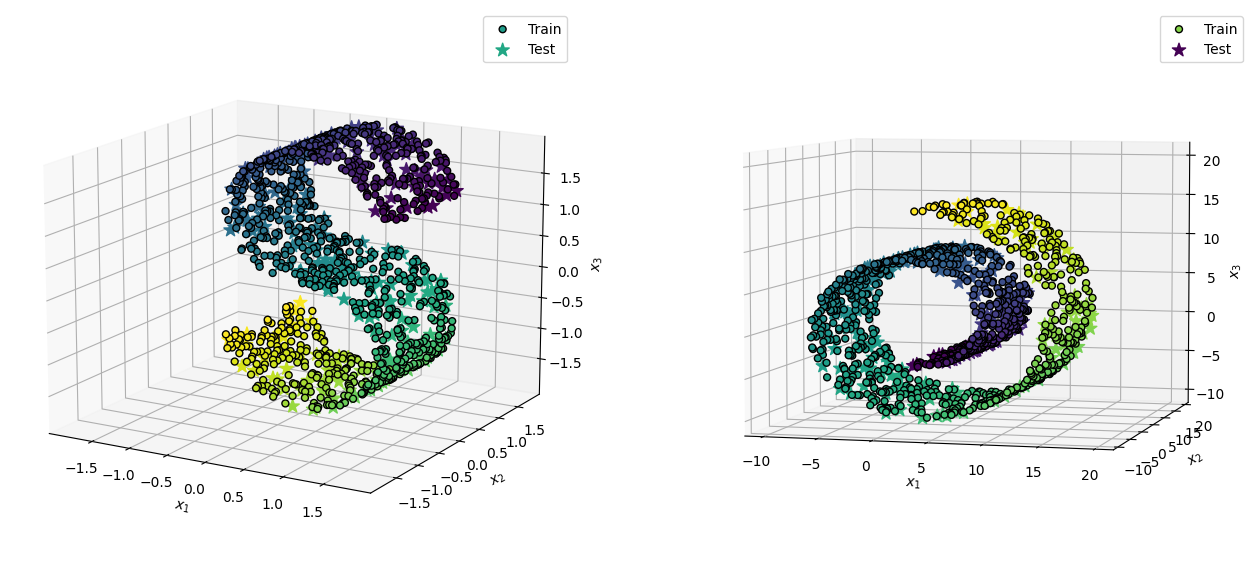

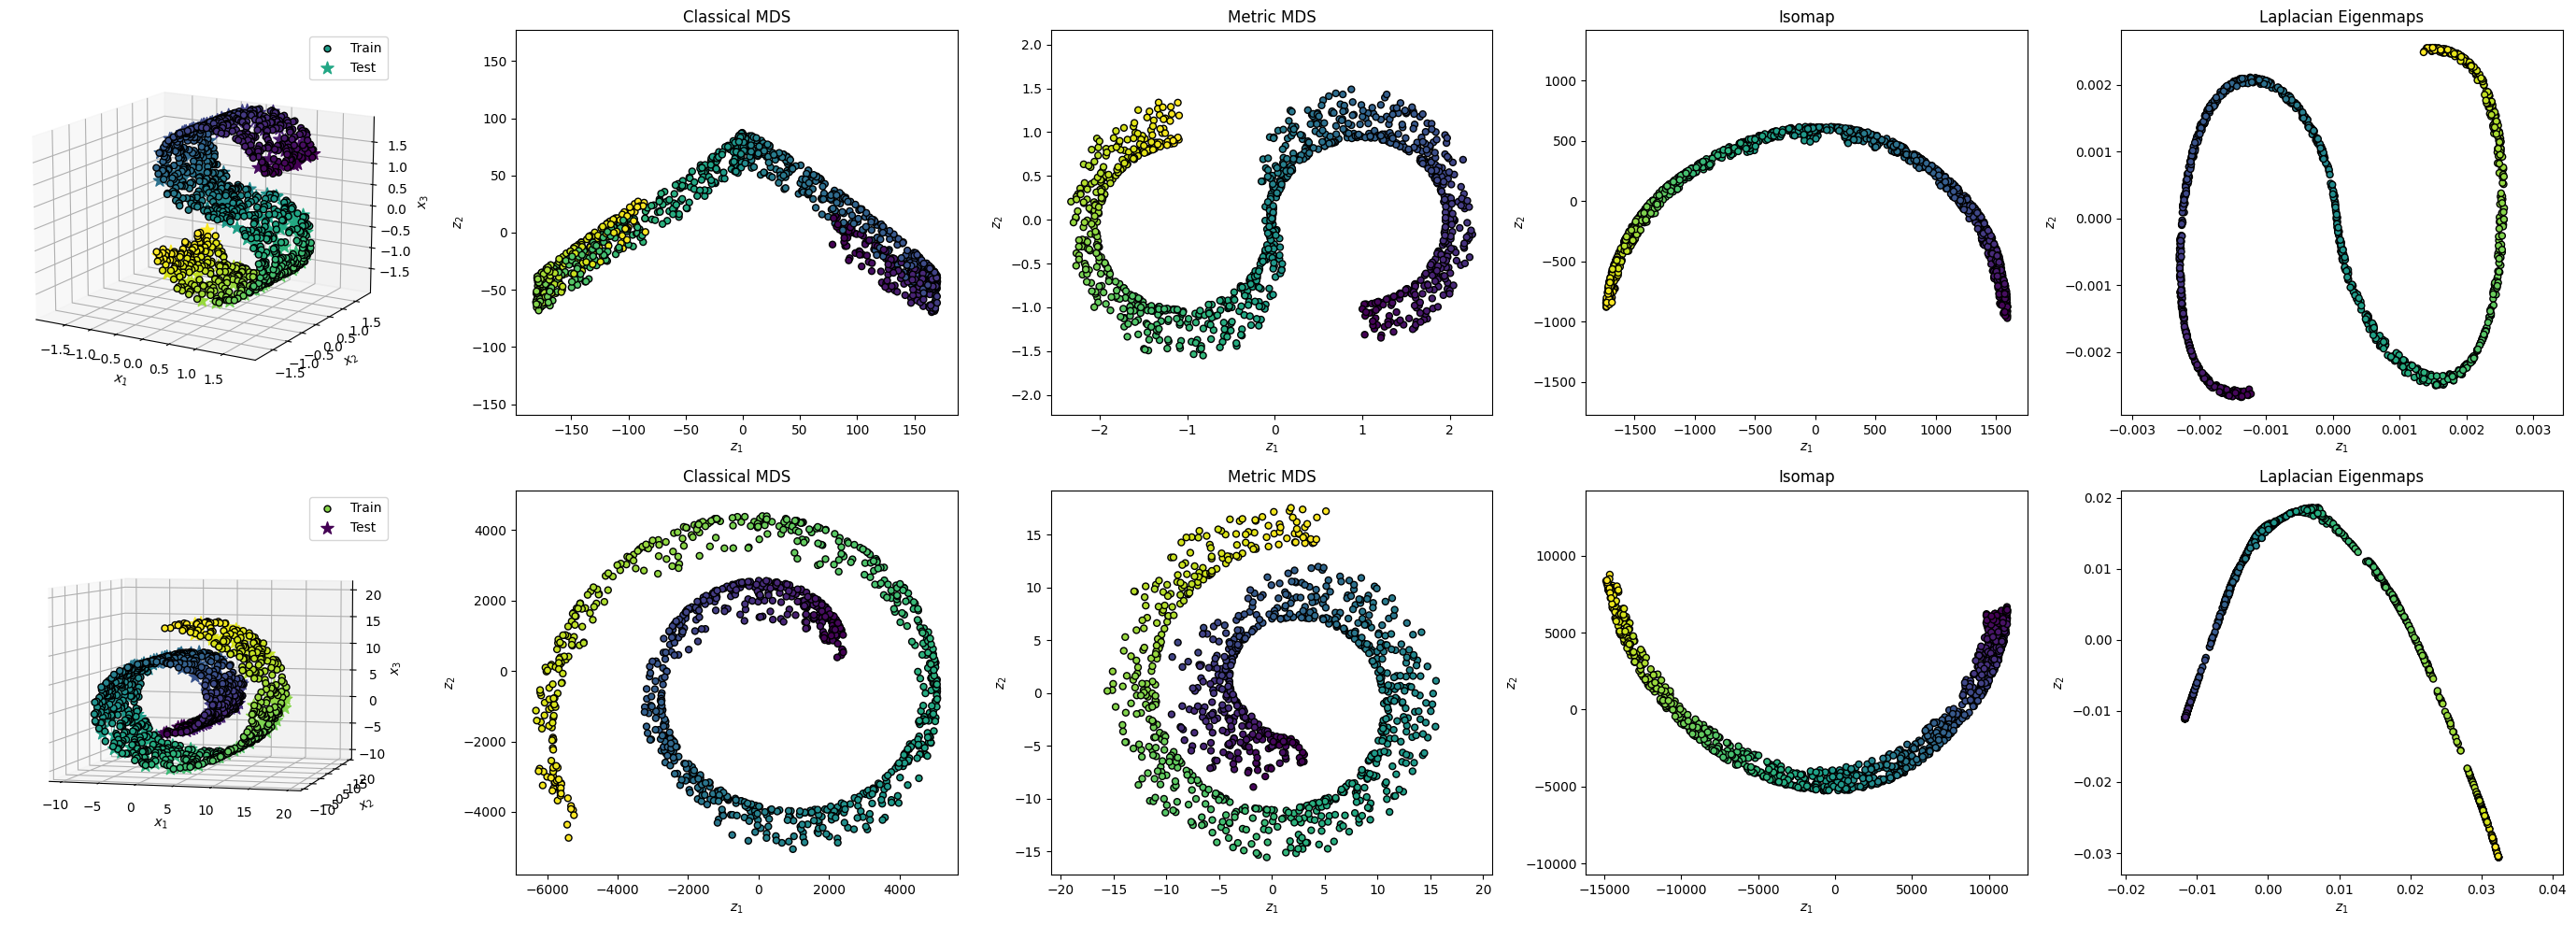

In [8]:
from sklearn.metrics import pairwise_distances


lData     = []
lData    += [(mX1, mY1, vCx1, vCy1)]
lData    += [(mX2, mY2, vCx2, vCy2)]

lMethods  = []
lMethods += [(CMDS(d=2),       'Classical MDS')]
lMethods += [(MMDS(d=2),       'Metric MDS')]
lMethods += [(Isomap            (d=2, K=8),  'Isomap')             ]
lMethods += [(LaplacianEigenmaps(), 'Laplacian Eigenmaps')]



fig, mAxes = plt.subplots(2, 5, figsize=(28, 10))
for ii, (mX, mY, vCx, vCy) in enumerate(lData):
    mDxx = pairwise_distances(mX.T      )
    mDxy = pairwise_distances(mX.T, mY.T)
    
    for jj, (oMap, name) in enumerate(lMethods, 1):
        if   name == 'Classical MDS'      : mZx = oMap.FitTransform(mDxx**2); mZy = np.full((2, Ny), np.nan) #todo: fix mZy = oMap.Transform(mDxy**2)            
        elif name == 'Metric MDS'         : mZx = oMap.FitTransform(mDxx)   ; mZy = np.full((2, Ny), np.nan)
        elif name == 'MetricMDS3'         : mZx = oMap.FitTransform(mDxx)   ; mZy = np.full((2, Ny), np.nan)
            
        #elif name == 'Isomap'             : mZx = oMap.FitTransform(mX)     ; mZy = oMap.Transform(mY)
        elif name == 'Isomap'             : mZx = oMap.FitTransform(mX)     ; mZy = np.full((2, Ny), np.nan)
            
        elif name == 'Laplacian Eigenmaps': mZx = oMap.FitTransform(mX.T)      ; mZy = np.full((2, Ny), np.nan)
        
        
        ax = mAxes[ii,jj]
        ax.scatter   (*mZx, s=25,  c=vCx, edgecolor='k')
        ax.scatter   (*mZy, s=100, c=vCy, marker='*')
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
        ax.set_title (name)
        ax.axis      ('equal')
    
    mAxes[ii,0].remove()
    PlotData(mX, mY, vCx, vCy, fig.add_subplot(2, 5, 1+5*ii, projection='3d'))

fig.axes[-2].view_init(elev=15, azim=300)
fig.axes[-1].view_init(elev=5,  azim=285)

plt.tight_layout()
plt.show()

In [9]:
from scipy.io import loadmat

mX = loadmat('Rings5.mat')['pointCloud']
mX.shape

(3, 1000)

#### Plot data (and apply K-Means):

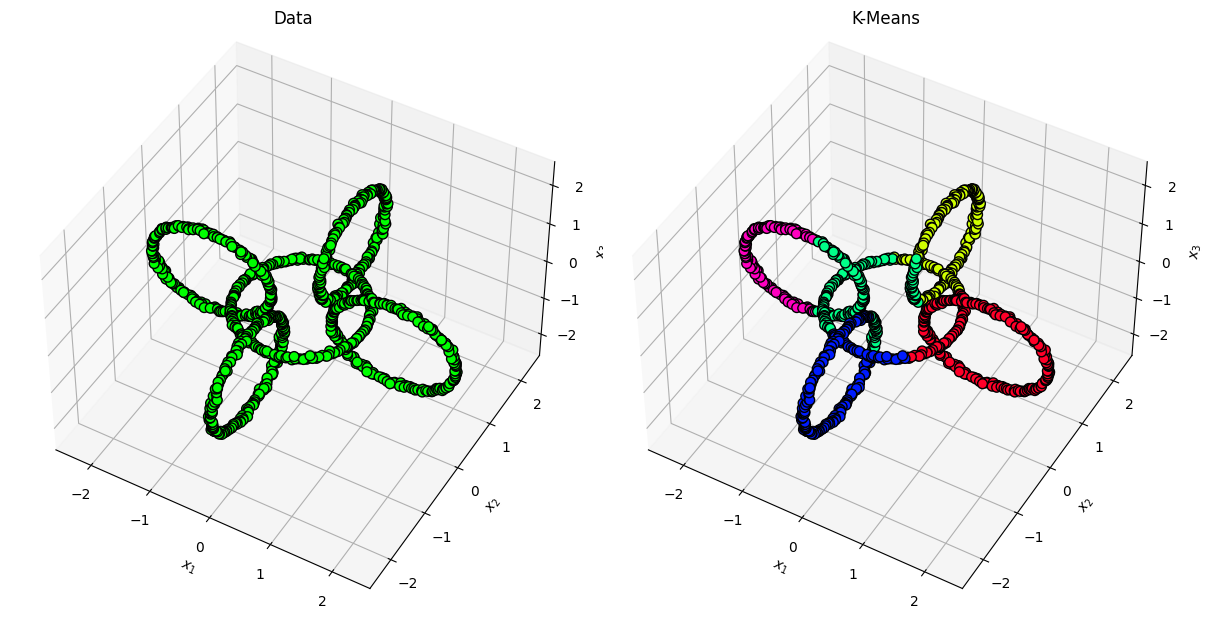

In [10]:
from sklearn.cluster import KMeans
from matplotlib.cm   import get_cmap

def PlotRings(mX, vC, title, ax):
    m = mX.min()
    M = mX.max()
    ax.scatter   (*mX, s=50,  c=vC, edgecolor='k', alpha=1, cmap=get_cmap('gist_rainbow', len(np.unique(vC))))
    ax.set_xlim  ([m, M])
    ax.set_ylim  ([m, M])
    ax.set_zlim  ([m, M])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_3$')
    ax.view_init (elev=45, azim=300)
    ax.set_title (title)

vIdxKMeans = KMeans(5).fit_predict(mX.T)
    
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, 'lime',     'Data',    ax1)
PlotRings(mX, vIdxKMeans, 'K-Means', ax2)

plt.tight_layout()
plt.show        ()

In [ ]:
K  = 5
'''
==============================================
Write your code below.
It should be 1-5 lines of code
==============================================
'''
vIdxSC = ???

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
PlotRings(mX, vIdxKMeans, 'K-Means',             ax1)
PlotRings(mX, vIdxSC,     'Spectral Clustering', ax2)

plt.tight_layout()
plt.show        ()

* Implement Spectral-Clustering:
    * Apply Laplacian-Eigenmaps with $d=K$, keep the first eigenvector (if it is not constant).
    * Apply K-Means, you may use `sklearn.cluster.KMeans`.
    * You might need to add one line of code to your `LaplacianEigenmaps` class.

# t-SNE
## 4.6 Perplexity - setting the variances
Implement the function `ComputeSTD`.
* Given:  
    * The point $\boldsymbol{x}_{i}\in\mathbb{R}^{D}$.
    * $\mathcal{N}_{i}$, the $K$th nearest neighbors of $\boldsymbol{x}_i$ (exclusive $\boldsymbol{x}_i$).
    * `PP` The perplexity value.
* The function computes $\sigma_{i}\pm\epsilon$, such that:
$$2^{H\left(\boldsymbol{x}_{i}\right)}=PP$$
where:
    $$H\left(\boldsymbol{x}_{i}\right)=-\sum_{j=1}^{K}p_{j|i}\log\left(p_{j|i}\right)$$
    
**Tip:** Since $2^{H\left(\boldsymbol{x}_{i}\right)}$ is monotonic increasing with $\sigma_{i}$, use binary search.

**Note:**
Compute all STDs with a **single** (binary search) loop.

In [11]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

def ComputeSTD(mD, PP, ε=1e-2):
    '''
    ===============================================================================
    Compute the std σ (for each data-point)
    Args:
        mD - The distance from each point to its K'th nearset neighbors, mD.shape = (N, K)
        PP - Perplexity value,                                           PP > 0
        ε  - threshold for the binary search,                            ε  > 0
    Output:
        vσ - The std,                                                    vσ.shape = (N,)                              
    ===============================================================================
    ''' 
    
    '''
    ==============================================
    Write your code below.
    It should be 10-15 lines of code
    ==============================================
    '''
    vσ = np.zeros(mD.shape[0])
    
    for i in range(mD.shape[0]):
        func = lambda sig: perp(p_conditional(mD[i:i + 1, :], np.array([sig])))
        vσ[i] = search(func, PP, ε)
    
    return vσ

def perp(condi_matr):
    ent = -np.sum(condi_matr * np.log2(condi_matr), 1)
    return 2 ** ent


def p_conditional(dists, sigmas):
    e = np.exp(-dists / (2 * np.square(sigmas.reshape((-1,1)))))
    np.fill_diagonal(e, 0.)
    e += 1e-8
    return e / e.sum(axis=1).reshape([-1,1])

def search(func, goal, ε, max_iters=1000, lowb=1e-20, uppb=10000):
    for _ in range(max_iters):
        guess = (uppb + lowb) / 2.
        val = func(guess)

        if val > goal:
            uppb = guess
        else:
            lowb = guess

        if np.abs(val - goal) <= ε:
            return guess

    return guess

#### Test your implementation:

In [12]:
from sklearn.datasets  import make_blobs
from sklearn.neighbors import NearestNeighbors

mX, _  = make_blobs(n_samples=1000, centers=[[-2,3], [0,-2], [2,2]], cluster_std=[.1,.3,.5])
oNN    = NearestNeighbors(n_neighbors=50).fit(mX)
mD, _  = oNN.kneighbors(mX, return_distance=True)

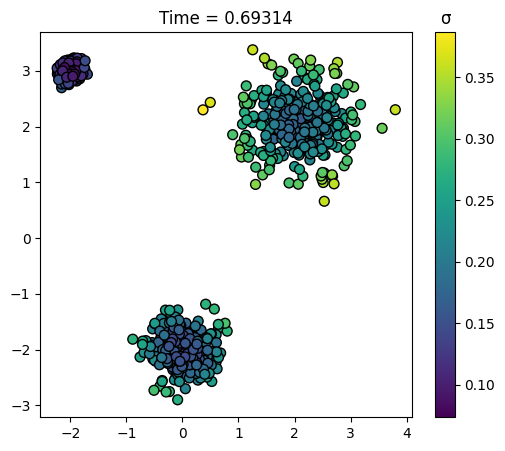

In [13]:
import time

PP    = 30
start = time.time ()
vσ    = ComputeSTD(mD, PP)
end   = time.time ()

_, ax = plt.subplots(figsize=(6, 5))
h     = ax.scatter(*mX.T, s=50, c=vσ, edgecolor='k')
ax.axis     ('equal')
ax.set_title(f'Time = {end - start:6.5f}')
plt.colorbar(h, ax=ax).ax.set_title('σ')

plt.show()

## 4.7 Implement `TSNE`
Implement the following `TSNE` class:
* `FitTransform` - Given $\boldsymbol{X}\in\mathbb{R}^{D\times N}$, obtains a low-dimensional representation.

**Notes:**
* Use must use a **single** loop.
* Use gradient descent with momentum.
* You may use the dynamic plot part for a nice visual animation of the algorithm:
    * Only works on `Jupyter`
    * Use `%matplotlib notebook` (instead of `%matplotlib inline`)
    * If you do not this, plot the final result with a `scatter` plot.
* **3% Bonus: Optimization tricks**
    * *Early compression:* In the first (50) iterations, add the penalty $\lambda\left\Vert \boldsymbol{Z}\right\Vert _{F}^{2}$ to the objective.  
    (**Update** your gradient accordingly)
    
    * *Early exaggeration:* In the first (50) iterations, use $4\boldsymbol{P}$ instead of $\boldsymbol{P}$.
    * After (about 100-200) iterations, update the momentum to $\beta=0.8$.
    


In [14]:
from scipy.sparse import csr_matrix

class TSNE:
    
    def __init__(self, d=2, K=50, PP=20, numIter=300, µ=100, ß=0.5, λ=1e-4, early_exaggeration=None):
        '''
        ========================================================================
        Set the hyper-parameters
        Args:
            d       - The output dimensionality.
            K       - Number of neareast neighbors.
            PP      - The perpelxity value.
            numIter - Number of iterations.
            µ       - Step size.
            ß       - Momentum decaying factor
            λ       - L² regularization factor (Early compression).
        ========================================================================
        '''
        self.d = d
        self.K = K
        self.PP = PP
        self.numIter = numIter
        self.µ = µ
        self.ß = ß
        self.λ = λ
        self.early_exaggeration = early_exaggeration

    def FitTransform(self, mX, vY=None):
        '''
        ========================================================================
        Applies the t-SNE algorithm
        Args:
            mX   - Input data,                                  mX.shape = (D, N)
            [vY] - Input labels, optional for dynamic plot,     vY.shape = (N,)
        Output:
            mZ   - Low-dimensional representation (embeddings), mZ.shape = (d, N)
        ========================================================================
        '''
        d = self.d
        K = self.K
        PP = self.PP
        numIter = self.numIter
        µ = self.µ
        ß = self.ß
        λ = self.λ

        N, D = mX.shape
        # -- Compute σ:
        knn = NearestNeighbors(n_neighbors=K, metric='euclidean')
        knn.fit(mX.T)
        distances_nn = knn.kneighbors_graph(mode="distance")
        del knn
        distances_nn.data **= 2
        # -- Compute P:
        P = self._joint_probabilities(distances_nn, PP)

        # -- Initialaization:
        mZ = np.random.normal(0., 0.0001, [D, d])
        mZ_m2 = mZ.copy()
        mZ_m1 = mZ.copy()

        if self.early_exaggeration is not None:
            P = P * self.early_exaggeration[1]

        # -- Dynamic plot:
        color = 'b' if vY is None else vY
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.axis('equal')
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
        s = ax.scatter(*mZ.T)
        cax = None

        for ii in range(numIter):

            if self.early_exaggeration is not None and ii == self.early_exaggeration[0]:
                P = P / self.early_exaggeration[1]

            # -- Compute Q:
            Q, distances = self._q(mZ)

            # -- Compute gradient:
            grads = self._grad(P, Q, mZ, distances)

            # print('µ {}'.format(µ))

            mZ = mZ - µ * grads

            if ß:
                mZ += ß * (mZ_m1 - mZ_m2)
                mZ_m2 = mZ_m1.copy()
                mZ_m1 = mZ.copy()

            # -- Dynamic plot:
            s.remove()
            s = ax.scatter(*mZ.T, s=25, c=color, edgecolor='k', cmap='tab10', vmin=-1 / 2,
                           vmax=len(np.unique(color)) - 1 / 2)
            ax.set_title(f'{ii}')
            cax = plt.colorbar(s, ax=ax, cax=cax).ax.axes
            fig.canvas.draw()
            plt.pause(1e-6)

        return mZ

    def _joint_probabilities(self, distances, desired_perplexity):
        distances.sort_indices()
        n_samples = distances.shape[0]
        distances_data = distances.data.reshape(n_samples, -1)
        distances_data = distances_data.astype(np.float32, copy=False)
        sigmas = ComputeSTD(distances_data, desired_perplexity)
        conditional_P = p_conditional(distances_data, sigmas)

        assert np.all(np.isfinite(conditional_P)), "All probabilities should be finite"

        P = csr_matrix(
            (conditional_P.ravel(), distances.indices, distances.indptr),
            shape=(n_samples, n_samples),
        )
        P = P + P.T
        sum_P = np.maximum(P.sum(), np.finfo(np.double).eps)
        P /= sum_P
        
        return P

    def _neg_squared_euc_dists(self, X):
        sum_X = np.sum(np.square(X), 1)
        D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
        return -D

    def _q(self, Y):
        distances = self._neg_squared_euc_dists(Y)
        inv_distances = np.power(1. - distances, -1)
        np.fill_diagonal(inv_distances, 0.)
        return inv_distances / np.sum(inv_distances), inv_distances

    def _grad(self, P, Q, Y, distances):
        pq_diff = P - Q
        pq_expanded = np.expand_dims(pq_diff, 2)
        y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
        distances_expanded = np.expand_dims(distances, 2)
        y_diffs_wt = y_diffs * distances_expanded
        grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
        return grad

#### Test your implementation:

In [15]:
from sklearn.datasets import load_digits

mX, vY = load_digits(return_X_y=True)
mX.shape, vY.shape

((1797, 64), (1797,))

<IPython.core.display.Javascript object>


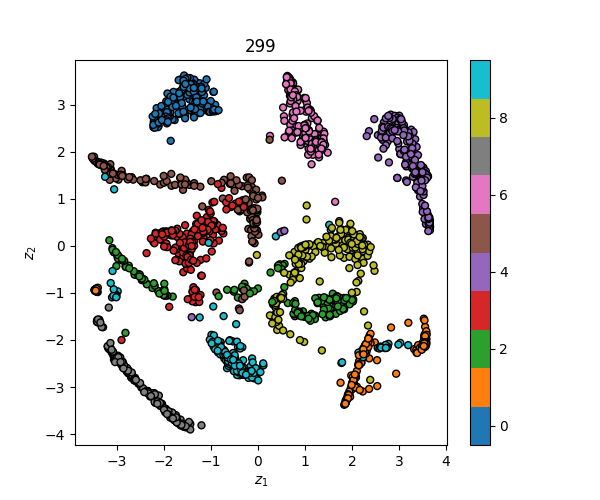

In [16]:
%matplotlib notebook

mZ = TSNE(µ=25, K=50, PP=30).FitTransform(mX.T, vY)

# 5 BCI (Brain-Computer Interface) data
**The original datasets (datasets 2a):**  
http://www.bbci.de/competition/iv/#dataset2a

**Download from here:** [BciData.npz](https://drive.google.com/file/d/13KPmsZ9Sr4lux6R5MOLvt3LzdaOpTBAc/view?usp=sharing)

**TL;DR**:
* Motor-imagery classification task (4 labels - `['Left hand', 'Right hand', 'Foot', 'Tongue']`)
* Each sample is a multi-variate time series with $C=22$ channels.
* 4 seconds, 250 samples per second ($T=1,000$).

#### Load and plot the dataset:

In [17]:
dData = np.load('BciData.npz')
mX   = dData['mX1']
vY   = dData['vY1']

mX.shape, vY.shape

((287, 1000, 22), (287,))

In [18]:
lLabel  = ['Left hand', 'Right hand', 'Foot', 'Tongue'] #-- The labels
N, T, C = mX.shape                                      #-- N = Samples, T = Time, C = Channels

#### Run the cell below several times

<IPython.core.display.Javascript object>


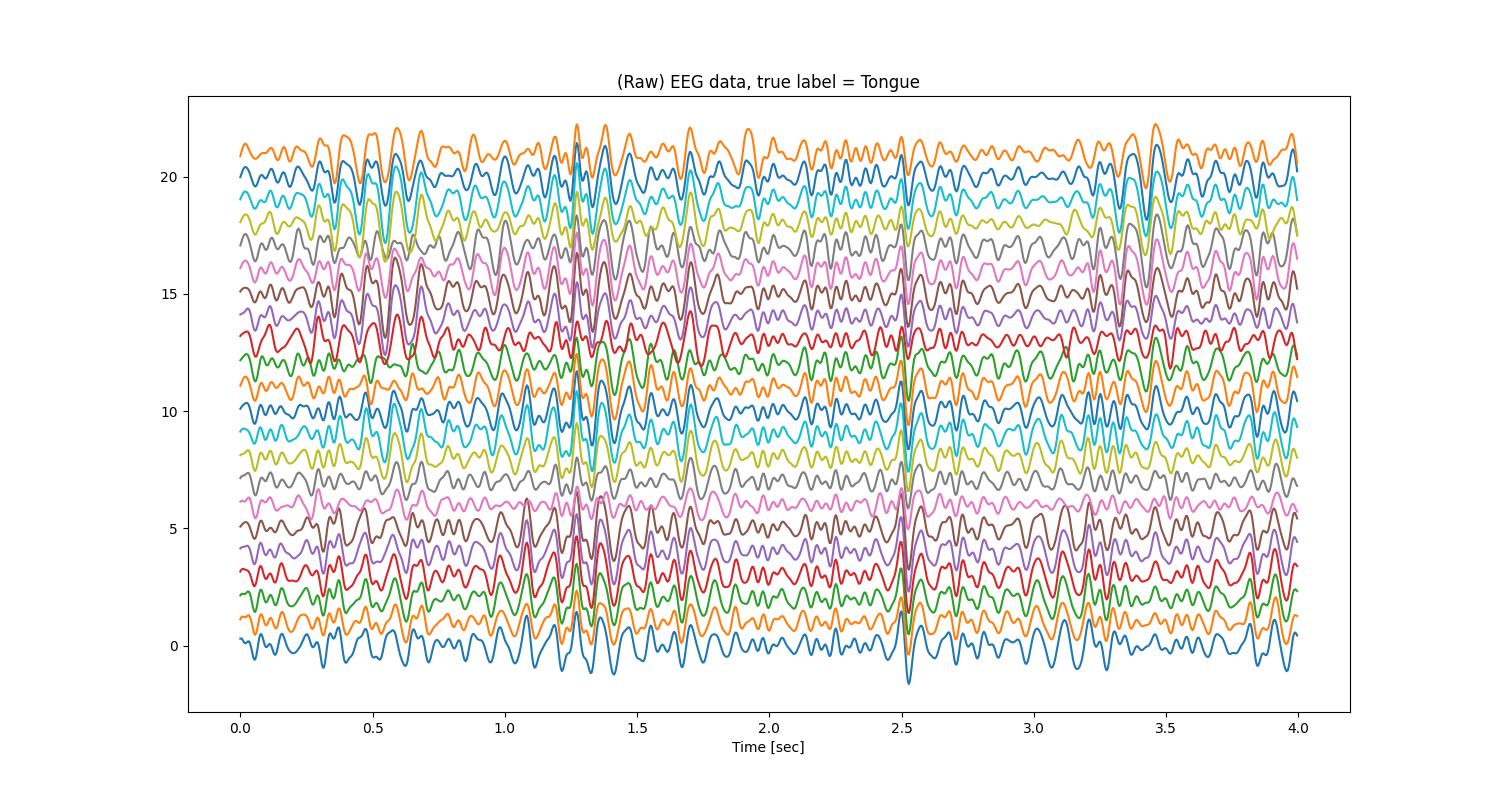

In [19]:
def PlotRandomSample(mX, vY):
    N, T, C = mX.shape #-- Samples, Time, Channels
    idx     = np.random.randint(N)
    mXi     = mX[idx,:,:].copy()
    yi      = vY[idx]
    
    #--  Just for plotting:
    mXi -= mXi.mean(0)
    mXi /= 20
    mXi += np.arange(C)[None,:]
    vT   = np.linspace(0, 4, T, endpoint=False)
    
    plt.figure(figsize=(15, 8))
    plt.plot  (vT, mXi)
    plt.title (f'(Raw) EEG data, true label = {lLabel[yi]}')
    plt.xlabel('Time [sec]')

PlotRandomSample(mX, vY)
plt.show        ()

## Analyzing
### Raw data - Euclidean metric
The cell below applies several dimensionality reduction methods to the raw EEG data (from day I).  
As you can see (after running the cell), the different labels do not form uniform clusters.

**Notes:**
* Use `sklearn` implementations
* Consider installing `UMAP`:<br>https://umap-learn.readthedocs.io/en/latest/  
(If not, omit this option)

<IPython.core.display.Javascript object>


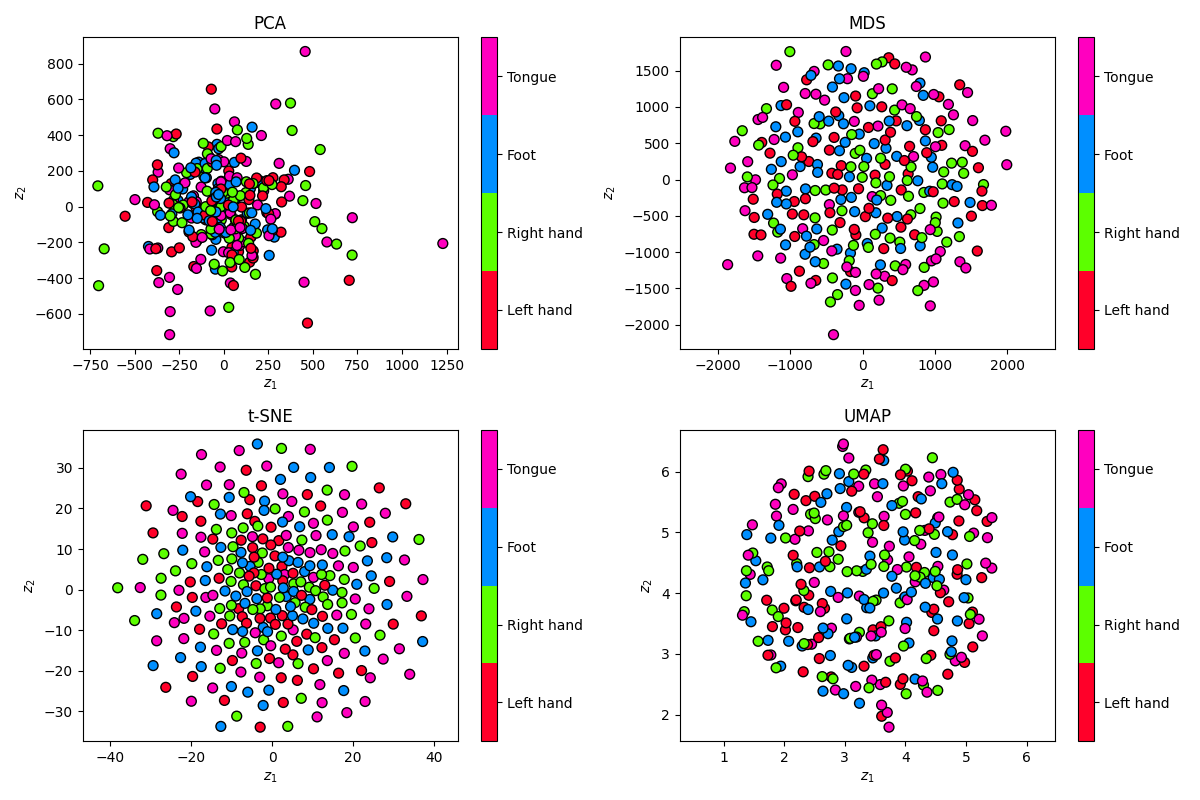

/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold      import MDS, TSNE
from umap                  import UMAP
from matplotlib.cm         import get_cmap

lMethods  = []
lMethods += [(PCA (n_components=2), 'PCA'  )]
lMethods += [(MDS (n_components=2), 'MDS'  )]
lMethods += [(TSNE(n_components=2), 't-SNE')]
lMethods += [(UMAP(n_components=2), 'UMAP' )]

mXA    = mX.reshape((N, -1))
fig, _ = plt.subplots(2, 2, figsize=(12, 8))
for (oMethod, name), ax in zip(lMethods, fig.axes):
    mZ = oMethod.fit_transform(mXA)
    
    h = ax.scatter(*mZ.T, s=50, c=vY, edgecolor='k', vmin=-1/2, vmax=3.5, cmap=get_cmap('gist_rainbow', 4))
    ax.set_title  (name)
    ax.set_xlabel ('$z_1$')
    ax.set_ylabel ('$z_2$')
    ax.axis       ('equal')
    plt.colorbar  (h, ax=ax, ticks=range(4)).ax.set_yticklabels(lLabel)   

plt.tight_layout()
plt.show        ()

---

## Feature extraction
* The raw data is inadequate as feature(s).
* Covariances (with a proper metric) are useful features for this task.
### 5.1
* Implement the following (short) `ComputeCovs` function.  
* **Do not use loops.**

In [21]:
def ComputeCovs(mX):
    '''
    ========================================================================
    The funciton computes the covariances of the input data
    Args:
        mX    - Input data,    mX   .shape = (N, T, C)
    Output:
        mCovs - N covariances, mCovs.shape = (N, C, C)
    ========================================================================
    '''
    
    '''
    ==============================================
    Write your code below.
    It should be 1-5 lines of code
    ==============================================
    '''

    means = np.mean(mX, axis=1)
    mx_features3 = np.subtract(mX, np.expand_dims(means, axis=1))

    mx_features3.shape, mX.shape

    mx_features4 = np.transpose(mx_features3, axes=(0,2,1))

    mCovs = np.matmul(mx_features4, mx_features3, axes=[(-2, -1), (-2, -1), (-2, -1)])



    return mCovs


---

### SPD metric (geodesic distance)
A useful metric between SPD matrices:
$$d\left(\boldsymbol{P},\boldsymbol{Q}\right)=\sqrt{\sum_{i=1}^{d}\log^{2}\left(\lambda_{i}\left(\boldsymbol{P}^{-1}\boldsymbol{Q}\right)\right)}$$
**Implementation:**

In [22]:
from scipy.linalg import eigvalsh

def SpdMetric(P, Q):
    '''
    ========================================================================
    The funciton computes the AIRM geodesic distance between two SPD matrices.
    Args:
        P    - An SPD matrix,         P.shape = (d, d)
        Q    - An SPD matrix,         Q.shape = (d, d)
    Output:
        dist - The geodesic distance, dist ≥ 0
    ========================================================================
    '''
    vEig = eigvalsh(P, Q)
    return np.linalg.norm(np.log(vEig))

#### `SpdMetricAux`
Gets the column stack representation of two SPD matrices and computes the `SpdMetric` between them.

In [23]:
def SpdMetricAux(vP, vQ):
    d2 = len(vP)
    d  = np.sqrt(d2).astype(np.int)
    mP = np.reshape(vP, (d, d))
    mQ = np.reshape(vQ, (d, d))
    
    return SpdMetric(mP, mQ)

### 5.2
* Apply the different dimensionality reduction methods to the covariances `mCovs`.
* Use the geodesic distance between your covariances:
    * For `MDS` - use the `precomputed` option with `mD`.
    * For `t-SNE`\\`UMAP` -  use `SpdMetricAux`.
* Remember to reshape `mCovs`.
* Fill the missing `???`.
* You should get much better results.

<ipython-input-23-b21d1e6e16c0>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d  = np.sqrt(d2).astype(np.int)


<IPython.core.display.Javascript object>


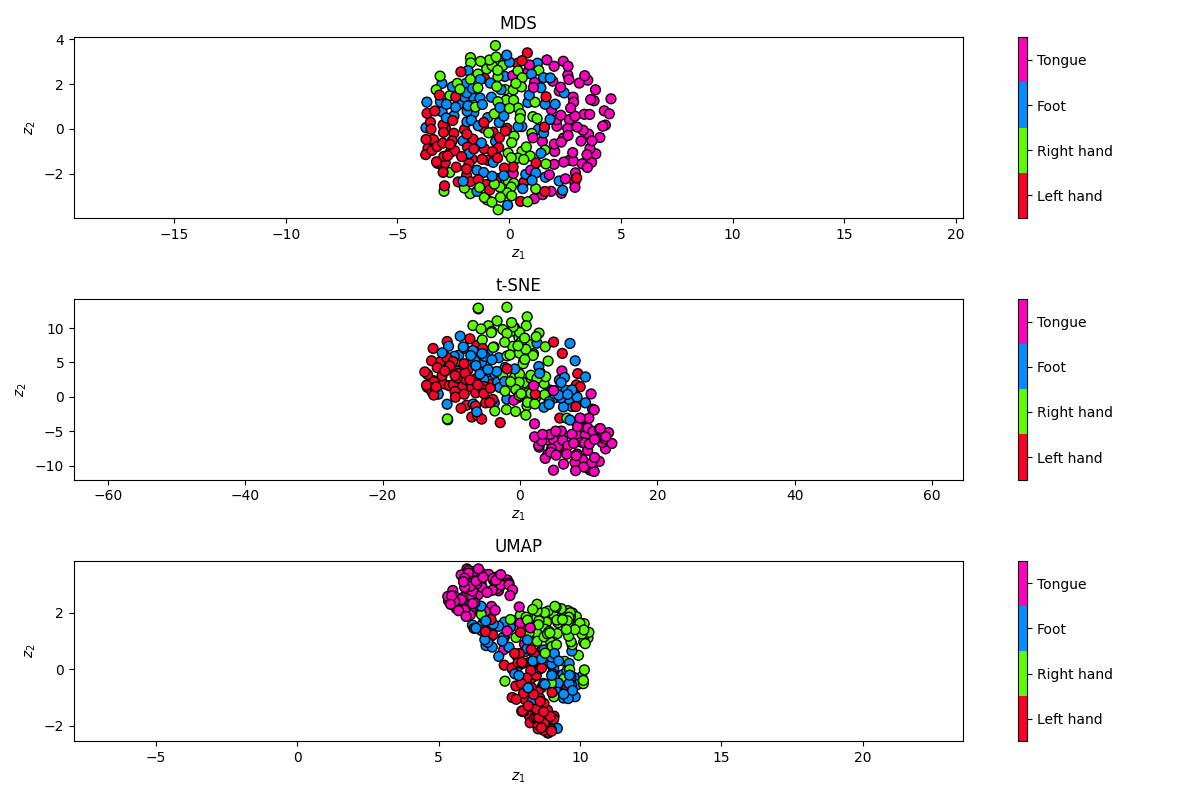

/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(
<ipython-input-23-b21d1e6e16c0>:3: DeprecationWarning: `np.int` is a deprecated al

In [24]:
from sklearn.metrics import pairwise_distances

mCovs = ComputeCovs(mX)
mD  = pairwise_distances(mCovs.reshape(N,-1), metric=SpdMetricAux)

lMethods  = []
lMethods += [(MDS (n_components=2, dissimilarity='precomputed'), 'MDS'  )]
lMethods += [(TSNE(n_components=2, metric=SpdMetricAux), 't-SNE')]
lMethods += [(UMAP(n_components=2, metric=SpdMetricAux), 'UMAP' )]

fig, _ = plt.subplots(3, figsize=(12, 8))

for (oMethod, name), ax in zip(lMethods, fig.axes):
    if name == 'MDS':
        mZ = oMethod.fit_transform(mD)
    else:
        mZ = oMethod.fit_transform(mCovs.reshape(287, -1))
    
    h = ax.scatter(*mZ.T, s=50, c=vY, edgecolor='k', vmin=-1/2, vmax=3.5, cmap=get_cmap('gist_rainbow', 4))
    ax.set_title  (name)
    ax.set_xlabel ('$z_1$')
    ax.set_ylabel ('$z_2$')
    ax.axis       ('equal')
    plt.colorbar  (h, ax=ax, ticks=range(4)).ax.set_yticklabels(lLabel)   
    
plt.tight_layout()
plt.show()

<ipython-input-54-b21d1e6e16c0>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  d  = np.sqrt(d2).astype(np.int)
/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gabib/anaconda3/envs/deidentification1/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/gabib/

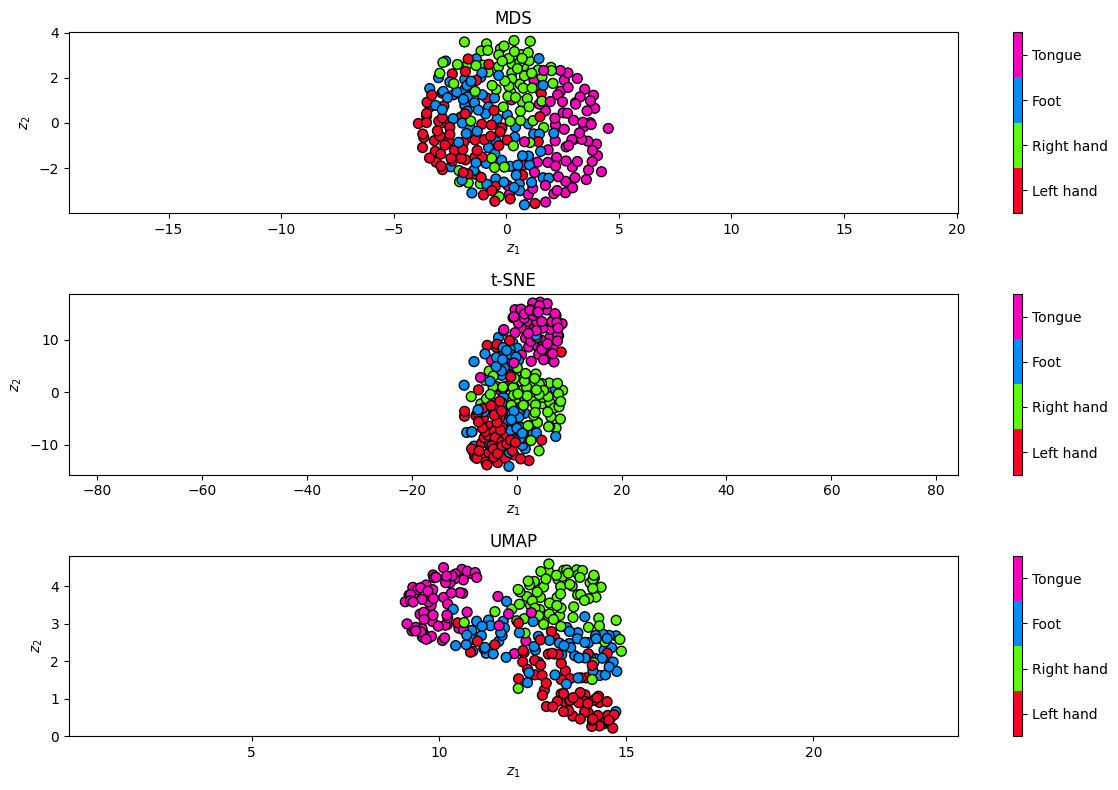

In [70]:
from sklearn.metrics import pairwise_distances

mCovs = ComputeCovs(mX)
mD  = pairwise_distances(mCovs.reshape(N,-1), metric=SpdMetricAux)

lMethods  = []
lMethods += [(MDS (n_components=2, dissimilarity='precomputed'), 'MDS'  )]
lMethods += [(TSNE(n_components=2, metric=SpdMetricAux), 't-SNE')]
lMethods += [(UMAP(n_components=2, metric=SpdMetricAux), 'UMAP' )]

fig, _ = plt.subplots(3, figsize=(12, 8))

for (oMethod, name), ax in zip(lMethods, fig.axes):
    if name == 'MDS':
        mZ = oMethod.fit_transform(mD)
    else:
        mZ = oMethod.fit_transform(mCovs.reshape(287, -1))
    
    h = ax.scatter(*mZ.T, s=50, c=vY, edgecolor='k', vmin=-1/2, vmax=3.5, cmap=get_cmap('gist_rainbow', 4))
    ax.set_title  (name)
    ax.set_xlabel ('$z_1$')
    ax.set_ylabel ('$z_2$')
    ax.axis       ('equal')
    plt.colorbar  (h, ax=ax, ticks=range(4)).ax.set_yticklabels(lLabel)   
    
plt.tight_layout()
plt.show()

### 5.3 (Bonus - supervised)
* Get the best leave-one-out cross validation accuracy on the BCI dataset.
* **Hints:**
    * Use the dimensionality reduction methods to extract useful features.
    * You may apply your dimensionality reduction to the entire dataset (train + test) as long as it is an unsupervised method.
    * $d$ does not have to be equal to $2$.
    * Above 85% accuracy is good (but one can do better).